In [4]:
#import JPype1
from konlpy.tag import Hannanum
from konlpy.utils import pprint
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from datetime import datetime, timedelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
import urllib.request
import urllib.parse
from urllib.request import urlopen
from bs4 import BeautifulSoup
import os
os.chdir('F:/news/newss')
# ## 주가 읽기

In [5]:
def read_file():
    stock = pd.read_csv("sk하이닉스.csv")
    stock['date'] = pd.to_datetime(stock['date'], format ='%Y-%m-%d')
    for i in range(len(stock)):
        stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)

    # # 뉴스 url읽기
    url = pd.read_csv("crawling_news2.txt", header = None, names = ["date","href"])
    url['per']= "A"
    return url, stock

In [6]:
url, stock = read_file()
print("read_file")

read_file


<ipython-input-5-19941ed10af7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['per'][i]=(float(stock['per'][i].replace("%",""))/100)


In [7]:
#전처리
def Pretreatment(url,stock):
    for i in range(len(url)):
        url['date'][i] = url['date'][i][:8]
        url['date'][i] = pd.to_datetime(url['date'][i], format ='%y.%m.%d')
        url['date'][i] = pd.Timestamp(url['date'][i]).date()
        while url['date'][i] not in list(stock['date']):
            url['date'][i]=url['date'][i]+timedelta(days=1)
        for j in range(len(stock)):
            if url['date'][i] == stock['date'][j]:
                url['per'][i] = stock['per'][j-1] #다음날 주가

    te4 = pd.DataFrame(url)
    te4 =te4.drop_duplicates(["date"])
    q1 = te4["per"].quantile(.25)
    q3 = te4["per"].quantile(.75)
    for i in range(len(url)):
        if url['per'][i] > q3:
            url['per'][i] = 0
        elif url['per'][i] <= q3 and url['per'][i]>0:
            url['per'][i] = 1
        elif url['per'][i] <= 0 and url['per'][i]>q1:
            url['per'][i] = 2
        else:
            url['per'][i] = 3
    return url

    # ### 퍼센트 원 핫 인코딩

    # ##### 원핫 인코딩 y값 제거해야 한다 함

    # from tensorflow.keras.utils import to_categorical
    # #float(te4["per"][1])
    # url['per'] = list(to_categorical(url['per']))
    #

In [8]:
url = Pretreatment(url,stock)
print("Pretreatment")

Pretreatment


In [92]:
#test와 train데이터 분리

# # 전처리 및 토큰화
def morpheme(data):
    news_group=[]
    j=0
    for i in range(len(data)):
        webpage = requests.get(data['href'][i])
        soup = BeautifulSoup(webpage.content, "html.parser")
        soup = soup.select_one('#newsViewArea').get_text()
        soup = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]', '', soup)
        if i == 0 :
            news_group_date = data['date'][i]
            news_group_content = soup
            count = 1
            news_group = pd.DataFrame([news_group_date,news_group_content,data['per'][i],count],['date','content','per','count']).transpose()
            continue
        if news_group['date'][j] == data['date'][i]:
            news_group['content'][j] = news_group['content'][j] + soup
            count + 1
            news_group['count'][j] = count
        else :
            j = j + 1
            count = 1
            a = {'date':data['date'][i],'content':soup,'per':data['per'][i],'count':count}
            news_group = news_group.append(a,ignore_index=True)
    return news_group

In [93]:
all_data=morpheme(url)
print("morpheme")


morpheme
           date                                            content per count
0    2021-05-06  급등하던 도지코인 가격이 급락으로 돌아서며 투자자들의 마음을 애태우고 있다 도지코인...   1     1
1    2021-05-05   공매도가 년개월 만에 재개된 가운데 정보기술IT과 철강소재 업종이 공매도 거래 비...   3     1
2    2021-05-04  이원욱 더불어민주당 의원이 일 반도체 수급 상황과 미국에 대한 투자 등을 볼 때 이...   2     1
3    2021-05-03   공매도를 부분 재개한 첫날인 일 한국 증시는 바이오주를 중심으로 대거 찬바람을 맞...   1     1
4    2021-03-22  코스피가 약보합 장세를 보이고 있습니다일 오전 시 분 코스피는 포인트 내린 을 나타...   3     1
..          ...                                                ...  ..   ...
158  2019-04-16  코스피가 오늘일 거래일 연속 상승했습니다이는 약 년 전 세워진 역대 최장 상승 행진...   2     1
159  2019-04-15   코스피가 거래일 연속 상승 마감했다 일 코스피는 전 거래일 대비 포인트 오른 에 ...   1     1
160  2019-03-18   한화투자증권은 일 SK하이닉스에 대해 분기 실적이 시장 예상치를 크게 하회할 전망...   1     1
161  2019-03-15  googletagdisplaygoogledfpMCx 테스SK하이닉스와 억원 규모 공...   2     1
162  2019-03-14   코스피가 네 마녀의 날쿼드러플 위칭 데이를 맞아 혼조양상을 보이다 장을 마쳤다일 ...   1     1

[163 rows x 4 columns]


In [94]:
print(all_data['count'])

0      1
1      1
2      1
3      1
4      1
      ..
158    1
159    1
160    1
161    1
162    1
Name: count, Length: 163, dtype: object


In [104]:
def text_except_all(data):
    tokken = []
    tok=[]
    hannanum=Hannanum()
    for i in range(len(data)):
        tokken.append(hannanum.pos(data['content'][i]))

    # ### 토큰 중 가장 긴 토큰을 기준으로 반복 및 형태소 중 명사 동사 선택

    lenA = []
    for i in range(len(tokken)):
        lenA.append(len(tokken[i]))
    max(lenA)

    
    Stopword = pd.read_csv("한국어불용어100.txt", header=None, names=['text','x','num'],delimiter = '\t')
    for i in range(len(tokken)):
        all_tokken=[]
        for j in range(lenA[i]):
            if tokken[i][j][1] == 'N' and tokken[i][j][0] not in Stopword['text'].values:
                all_tokken.append(tokken[i][j][0])
        tok.append(all_tokken)
    return tok

In [105]:

all_data['content'] = text_except_all(all_data)
# print("text_except")

In [106]:
all_data

,date,content,per,count
0,2021-05-06,"[급등, 도지코, 가격, 급락, 투자자들, 마음, 도지코인, 오후, 시, 분, 현재...",1,1
1,2021-05-05,"[공매도, 년개월, 만, 재개, 가운데, 정보기술IT, 철강소재, 업종, 공매, 비...",3,1
2,2021-05-04,"[이원욱, 더불어민주당, 의원, 반도체, 수급, 상황, 미국, 투, 이재용, 삼성전...",2,1
3,2021-05-03,"[공매도, 부분, 재개, 첫날, 한국, 증시, 바이오주, 중심, 찬바람, 코스닥, ...",1,1
4,2021-03-22,"[코스피, 약보합, 장세, 있습니다, 오전, 시, 분, 코스피, 포인트, 을, 나타...",3,1
...,...,...,...,...
158,2019-04-16,"[코스피, 오늘, 거래, 연속, 상승했습니다, 약, 역대, 최장, 상승, 행진, 동...",2,1
159,2019-04-15,"[코스피, 거래, 연속, 상승, 마감, 코스피, 거래, 대비, 포인트, 거래, 마쳤...",1,1
160,2019-03-18,"[한화투자증권, SK하이닉스, 분기, 실적, 시장, 예상치, 하회, 전망, 분기, ...",1,1
161,2019-03-15,"[테스SK하이닉스, 억원, 규모, 공급, 계약다날, 전환가액, 조정파인넥스억원, 규...",2,1


In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_tokken)

vocab_size = 1000  # 상위 500 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size + 1)
tokenizer.fit_on_texts(all_tokken)

# print(tokenizer.word_index) #인덱스가 어떻게 부여됬는지(입력된 단어 순서)
# print(tokenizer.word_counts) #상위 몇개 단어를 했을 때 어떻게 부여됬는지(입력된 단어 순서)

def text_size(num):
    threshold = num
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

    #단어수가 2개인 단어의 빈도가 6.1%라 유의미한 영향을 줄 수 있어 제외하지 않는다

    # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
    # 0번 패딩 토큰을 고려하여 + 1
    vocab_size = total_cnt - rare_cnt + 1
    print('단어 집합의 크기 :',vocab_size)


    # ## 앞의 형태소분석을 붙여씀
    # ### 불필요하게 주가를 넣는 부분이 있고 href에서 본문을 따오는 부분 함수화 고려

text_size(2)

단어 집합(vocabulary)의 크기 : 7776
등장 빈도가 1번 이하인 희귀 단어의 수: 4308
단어 집합에서 희귀 단어의 비율: 55.401234567901234
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.674693081827282
단어 집합의 크기 : 3469


In [134]:
def train_test(data):
    train, test = train_test_split(data, test_size= 0.2, random_state=1234)

    #인덱스 초기화
    train = train.reset_index()
    test = test.reset_index()
    return train, test

train, test = train_test(all_data)
print("train_test")

train_test


In [167]:
# train_data = morpheme(train)
# test_data = morpheme(test)

# train_data['content'] = text_except(train_data['content'])
# test_data['content'] = text_except(test_data['content'])

# X_train = train['content']
# X_test = test['content']
X_train = tokenizer.texts_to_sequences(train['content'])
X_test = tokenizer.texts_to_sequences(test['content'])

y_train = train['per']
y_train = pd.DataFrame(y_train)
y_test = test['per']
y_test = pd.DataFrame(y_test)


drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
# X_train = np.delete(X_train, drop_train, axis=0)
# y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

130
130


In [168]:
X_train

[[3,
  7,
  109,
  267,
  94,
  8,
  90,
  185,
  111,
  52,
  96,
  3,
  37,
  10,
  5,
  56,
  19,
  853,
  5,
  8,
  90,
  25,
  83,
  244,
  521,
  78,
  4,
  11,
  109,
  65,
  449,
  134,
  877,
  153,
  8,
  4,
  11,
  508,
  877,
  153,
  211,
  279,
  11,
  508,
  65,
  449,
  134,
  877,
  49,
  245,
  344,
  4,
  354,
  389,
  11,
  390,
  86,
  38,
  4,
  40,
  68,
  11,
  134,
  319,
  109,
  65,
  65,
  602,
  134,
  924,
  159,
  508,
  84,
  106,
  264,
  106,
  333,
  378,
  152,
  5,
  152,
  252,
  20,
  857,
  604,
  247,
  152,
  45,
  44,
  284,
  485,
  761,
  669,
  391,
  49,
  3,
  5,
  444,
  55,
  98,
  45,
  497,
  33,
  173,
  217,
  256,
  458,
  227,
  123,
  165,
  17,
  1,
  138,
  77,
  28,
  15,
  1,
  1,
  536,
  50,
  1,
  186,
  39,
  58,
  883,
  2,
  9,
  162,
  80,
  74,
  135,
  113,
  515,
  114,
  19,
  396,
  108,
  124,
  33,
  6,
  8,
  6,
  27,
  37,
  10,
  5,
  143,
  19,
  177,
  834,
  22,
  23,
  24,
  47],
 [3,
  523,
  269,
  194,

In [169]:
all_data['count']

0      1
1      1
2      1
3      1
4      1
      ..
158    1
159    1
160    1
161    1
162    1
Name: count, Length: 163, dtype: object

뉴스의 최대 길이 : 7
뉴스의 평균 길이 : 0.042222222222222223


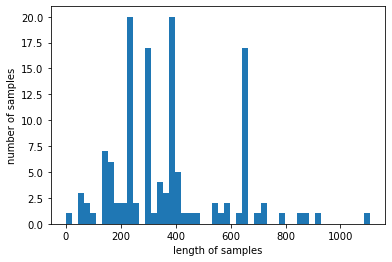

In [170]:
# ## 패딩

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


print('뉴스의 최대 길이 :',max(len(l) for l in all_data))
print('뉴스의 평균 길이 :',sum(map(len, all_data))/len(url))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [172]:
max_len = 800
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 800 이하인 샘플의 비율: 96.92307692307692


In [173]:

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)



X_train2 = pd.DataFrame(X_train)
X_train2=X_train2.astype('float64')
X_test2 = pd.DataFrame(X_test)
X_test2=X_test2.astype('float64')



y_train=y_train.astype('float64')
y_test=y_test.astype('float64')



X_train2 = np.array(X_train2).reshape(X_train2.shape[0], X_train2.shape[1], 1)
y_train = np.array(y_train).reshape(y_train.shape[0], y_train.shape[1], 1)
X_test2 = np.array(X_test2).reshape(X_test2.shape[0], X_test2.shape[1], 1)
y_test = np.array(y_test).reshape(y_test.shape[0], y_test.shape[1], 1)


# #### loss = sparse_categorical_crossentropy은 y값을 원핫인코딩하지 않는다
# y_train = to_categorical(y_train, 4)

In [174]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [188]:
model = Sequential()
#model.add(Embedding(vocab_size, 100)) #모델에 입력크기를 고정된 크기고 제한
#model.add(Dense(2, activation='softmax'))
model.add(LSTM(128, input_shape = (270,1),stateful=True))
#,return_sequences=True, input_shape = (300,1) 입력형식, stateful=True 상태유지
model.add(Dropout(0.2, input_shape=(270,1)))
initializer = tf.keras.initializers.HeNormal() #가중치 초기화
model.add(Dense(90, activation='relu',kernel_initializer=initializer))

model.add(Dense(90, activation='relu'))
model.add(Dense(4, activation='softmax'))

ValueError: If a RNN is stateful, it needs to know its batch size. Specify the batch size of your input tensors: 
- If using a Sequential model, specify the batch size by passing a `batch_input_shape` argument to your first layer.
- If using the functional API, specify the batch size by passing a `batch_shape` argument to your Input layer.

In [189]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc','sparse_categorical_accuracy'])
history = model.fit(X_train2, y_train, epochs=100, callbacks=[es, mc], batch_size=60, validation_split=0.2)
#validation_split 전체데이터(train)중 얼마를 학습할 것이냐
#batch_size 계산 후 가중치를 넘길 계산 단위

Epoch 1/100


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [48000,1] and labels shape [60]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-189-c15aa6a3ad33>:6) ]] [Op:__inference_train_function_70108]

Function call stack:
train_function


2/2 [==============================] - 1s 38ms/step - loss: 1.0722 - acc: 0.6364 - sparse_categorical_accuracy: 0.6364

 테스트 정확도: 0.6364


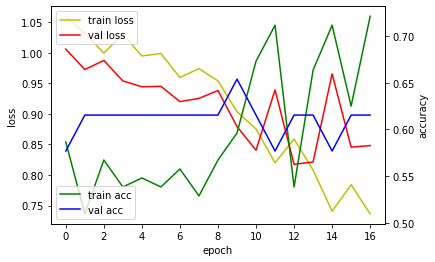

In [185]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test2, y_test)[1]))

# 학습 결과 그래프 그리기

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['sparse_categorical_accuracy'], 'g', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

# # 끝